In [207]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import folium
from sklearn import preprocessing
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
import statsmodels.api as sm
from sklearn import metrics
import datetime
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARMA


In [304]:
sns.set(rc={'figure.figsize':(20,10)})

<p> Data Uploads and Cleaning </p>

In [4]:
data = pd.read_csv('./assets/main.csv')
death_data = pd.read_csv('./assets/deaths.csv')

In [8]:
confirmed_data = pd.read_csv('./assets/Confirmed_time.csv')

In [9]:
confirmed_data.set_index('variable', inplace=True)

In [10]:
confirmed_data['Totals'] = confirmed_data.sum(axis=1)

In [608]:
def setting_index(x):
    x.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key', 'Population'],inplace=True,axis=1)
    x.set_index(['variable'],inplace=True)
    return pd.DataFrame(x.resample('D').sum())

In [ ]:
melt = pd.melt(data, id_vars=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key'])
melt['variable'] = pd.to_datetime(melt['variable'], infer_datetime_format=True)
melt.set_index('variable', inplace=True)

In [11]:
death_data.set_index('variable',inplace=True)
data.drop('Unnamed: 0', axis=1, inplace=True)
data.set_index('variable', inplace=True)

In [12]:
last_deaths = death_data.iloc[-1:]
death_cols = list(last_deaths.columns)
death_nums = [i for i in last_deaths.iloc[-1]]
graphing_df = pd.DataFrame({'States':death_cols, 'Deaths':death_nums})
graphing_df.drop([0,1,2,3,4,13,56,57], inplace=True)
graphing_df['States'] = [i.replace('_', ' ') for i in graphing_df['States']]

In [15]:
death_data['Totals'] = death_data.sum(axis=1)

##### Death Statistics

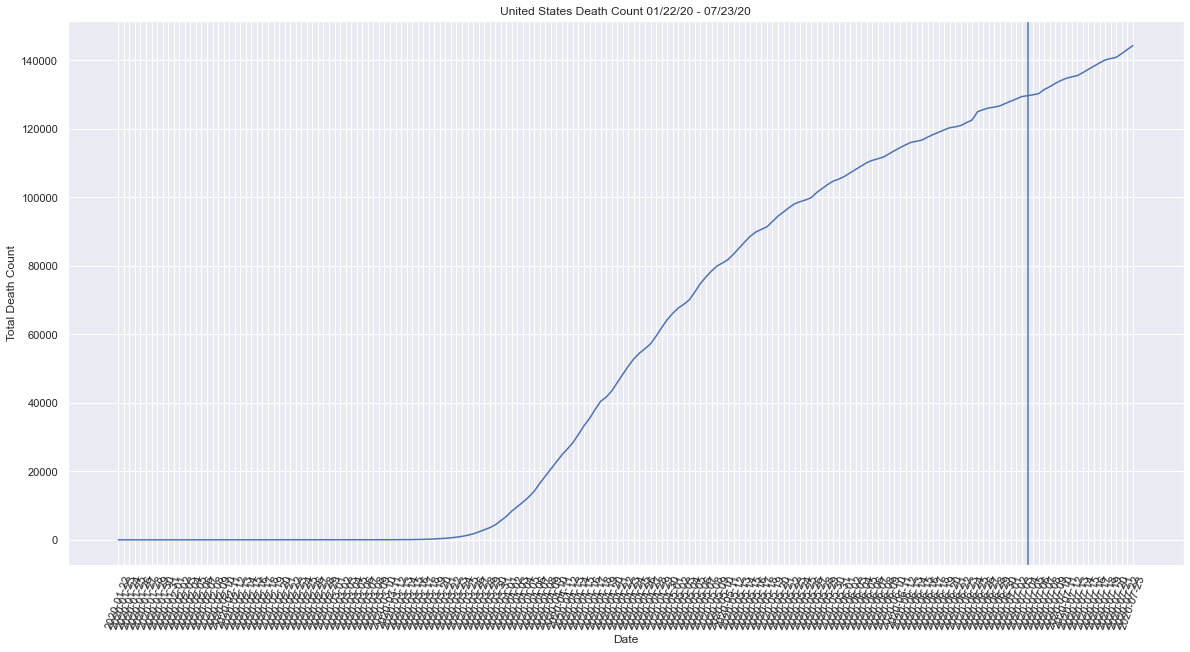

In [330]:
plt.figure()
death_chart = sns.lineplot(x=death_data.index,y=death_data['Totals']).set_xticklabels(labels=death_data.index,rotation=70)
plt.xlabel('Date')
plt.ylabel('Total Death Count')
plt.title('United States Death Count 01/22/20 - 07/23/20')
plt.axvline('2020-07-04')
plt.show()

### The first day of corona was 01/21/20 in Seattle, Washington

<p> The current death rate is increasing exponentially. <p>

<p> Based on our Dickey-Fuller Test, we have additional proof that the time series is not stationary. </p>

In [18]:
ind = death_data.index
test_df = pd.DataFrame([death_data['Totals']])
test_df = test_df.T

In [19]:
test_df.index=pd.to_datetime(test_df.index)

In [107]:
death_data['pct_change'] = death_data['Totals'].pct_change()

<p> Resampling the data </p>

In [122]:
weekly_rates = test_df.resample('w').mean()
monthly_rates = test_df.resample('m').mean()

[Text(0, 0, '2020-01-31 00:00:00'),
 Text(0, 0, '2020-02-29 00:00:00'),
 Text(0, 0, '2020-03-31 00:00:00'),
 Text(0, 0, '2020-04-30 00:00:00'),
 Text(0, 0, '2020-05-31 00:00:00'),
 Text(0, 0, '2020-06-30 00:00:00'),
 Text(0, 0, '2020-07-31 00:00:00')]

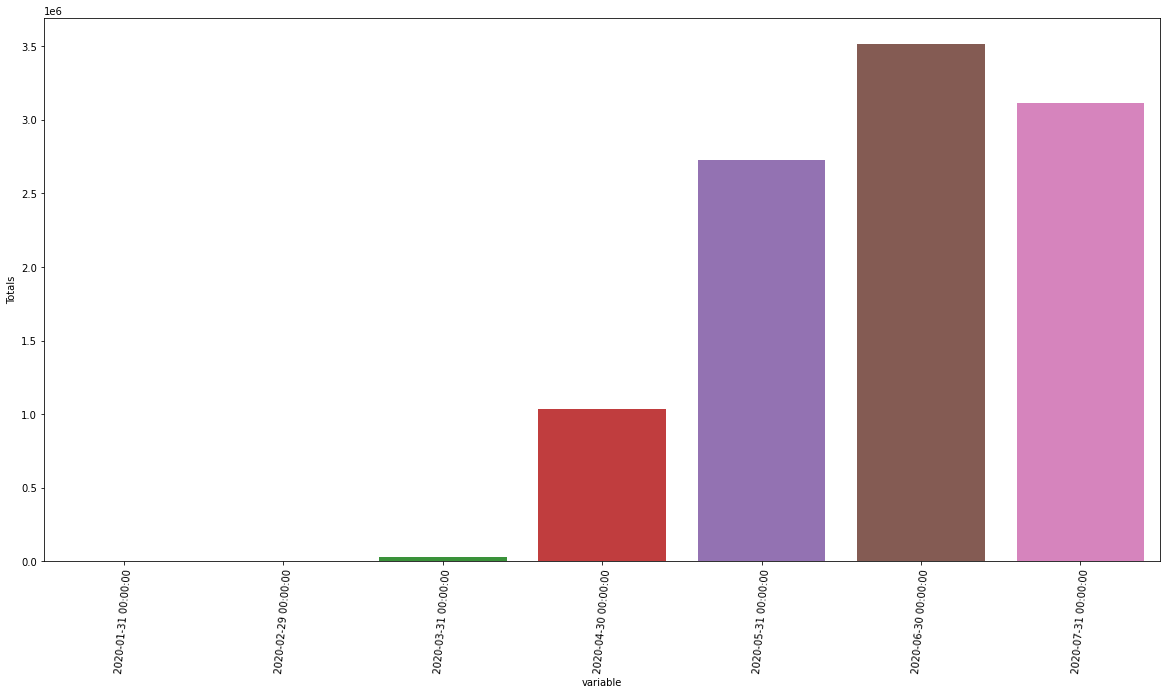

In [24]:
plt.figure(figsize=(20,10))
monthly_data = sns.barplot(x=monthly_rates.index, y=monthly_rates['Totals'])
monthly_data.set_xticklabels(labels=monthly_rates.index, rotation=85)

In [361]:
graphing_df = new_df
graphing_df.reset_index(inplace=True)

In [601]:
state_data.index[-5:]

Index(['Missouri', 'Kentucky', 'Virginia', 'Georgia', 'Texas'], dtype='object', name='Province_State')

##### Confirmed Cases

Text(0.5, 1.0, 'Top 10 States with Confirmed Cases')

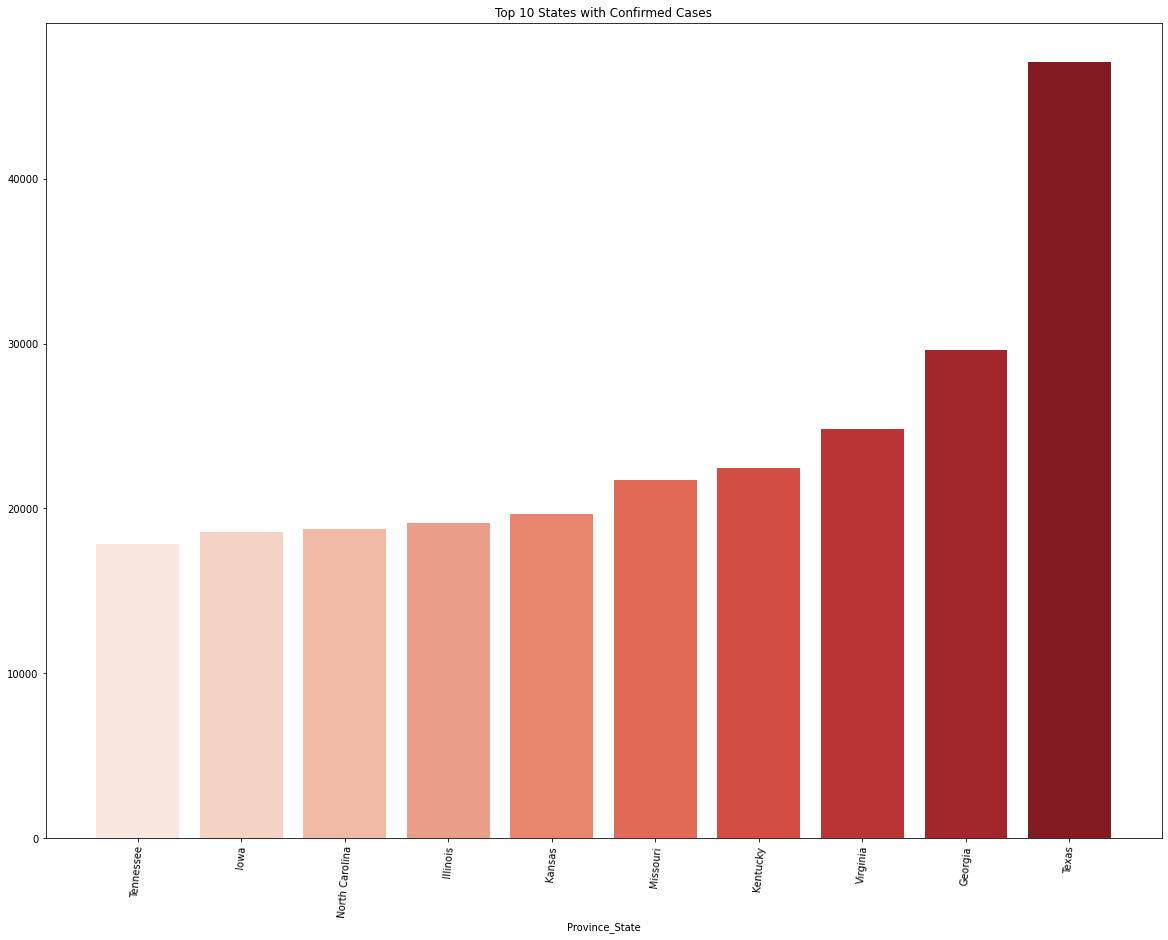

In [603]:
plt.figure(figsize=(20,15))
state_chart = sns.barplot(x=state_data.index[-10:], y=state_data.values[-10:] ,orient='v', palette='Reds')
state_chart.set_xticklabels(labels=state_data.index[-10:], rotation=85)
state_chart.plot()
plt.title('Top 10 States with Confirmed Cases')

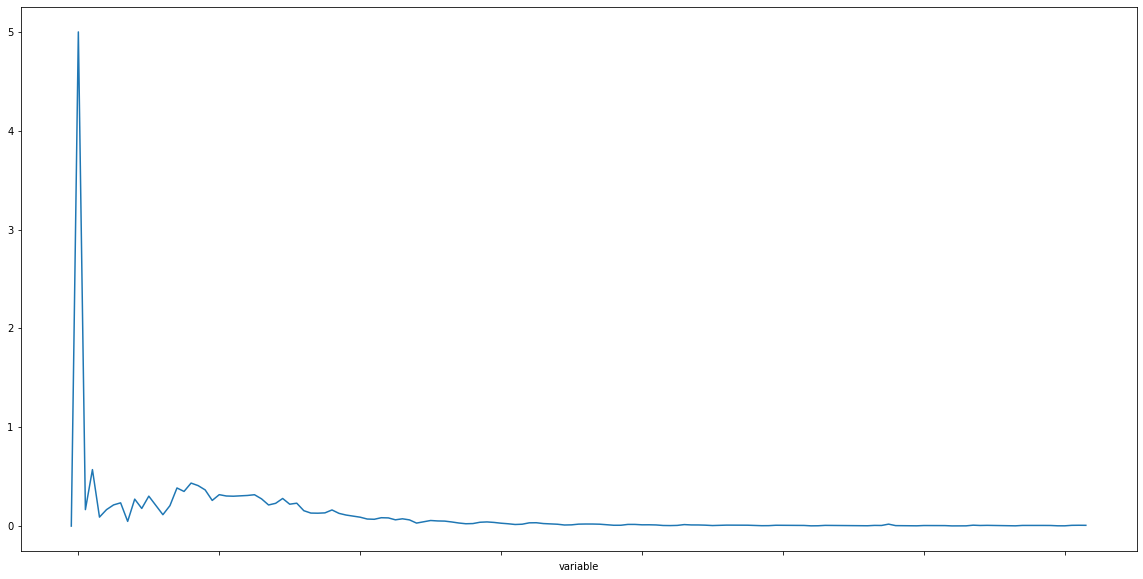

In [113]:
death_data['pct_change'].plot(figsize=(20,10))

<p> In the chart above, we can see the percentage change of the Total death rate. The rate had a very high increase, but has now leveled. However, it should be noted that the death rate of the virus is still increasing </p>

In [123]:
weekly_rates['pct_change'] = weekly_rates['Totals'].pct_change()

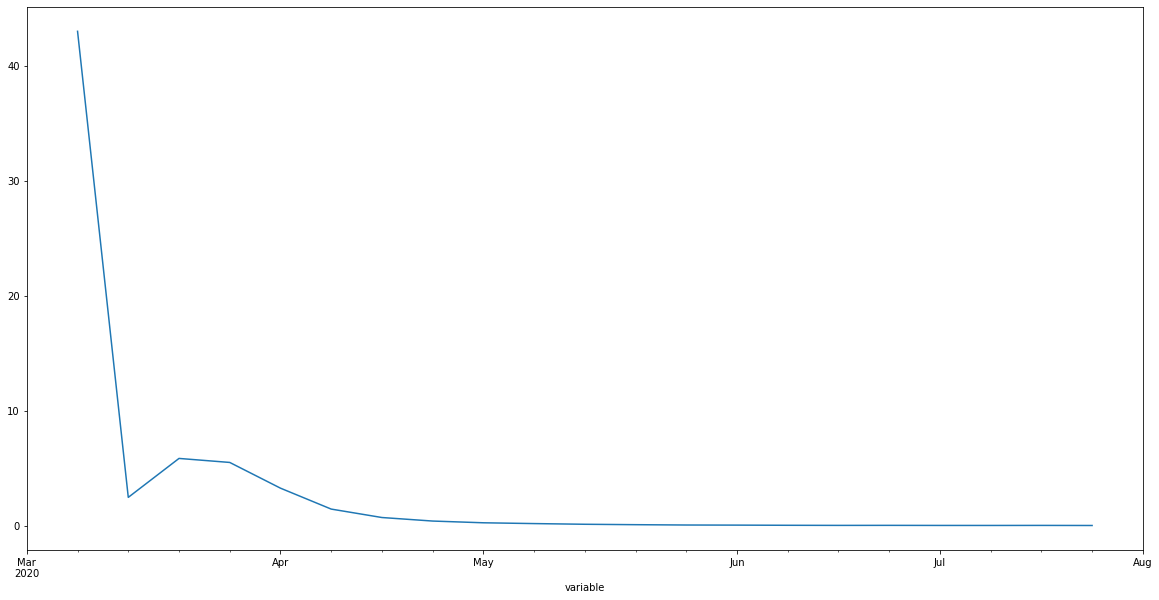

In [125]:
weekly_rates['pct_change'].plot(figsize=(20,10))

<p> Here is the weekly percentage change of the death rate. It's is similar to the chart above. </p>

<Figure size 1440x720 with 0 Axes>

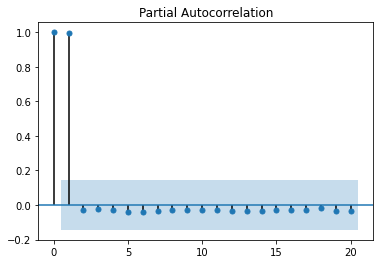

<Figure size 1440x720 with 0 Axes>

In [205]:
plot_pacf(death_data['Totals'], lags=20)
plt.figure(figsize=(20,10))

<Figure size 1440x720 with 0 Axes>

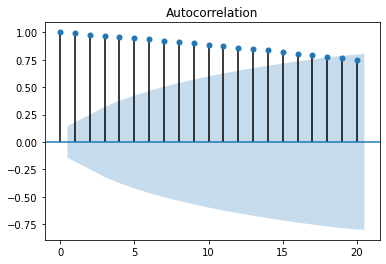

<Figure size 1440x720 with 0 Axes>

In [204]:
plot_acf(death_data['Totals'], lags=20)
plt.figure(figsize=(20,10))

In [216]:
def differencing(dataframe, num):
    return dataframe['Totals'].diff(periods=num)

In [238]:
three_times_dif = differencing(death_data,3)

In [236]:
def dickey_fuller_test(series):
    dftest = adfuller(series, autolag='AIC', regression='ctt')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

In [209]:
def run_arma(series, p,q):
    mod_arma = ARMA(series, order=(p,q))
    res_arma = mod_arma.fit()
    return res_arma.summary()

In [137]:
death_total = pd.DataFrame(death_data['Totals'])
death_total_diff1= death_total.diff()
death_total_diff2=death_total_diff1.diff()
dt_diff3 = death_total_diff2.diff()

In [273]:
dickey_fuller_test(death_data['Totals'])

Test statistic = -3.063
P-value = 0.266
Critical values :
	1%: -4.441022560115803 - The data is not stationary with 99% confidence
	5%: -3.867796785663158 - The data is not stationary with 95% confidence
	10%: -3.575112928425384 - The data is not stationary with 90% confidence


In [237]:
dickey_fuller_test(death_total_diff2[2:])

Test statistic = -2.680
P-value = 0.466
Critical values :
	1%: -4.43977965973908 - The data is not stationary with 99% confidence
	5%: -3.8671708983800173 - The data is not stationary with 95% confidence
	10%: -3.574728149306036 - The data is not stationary with 90% confidence


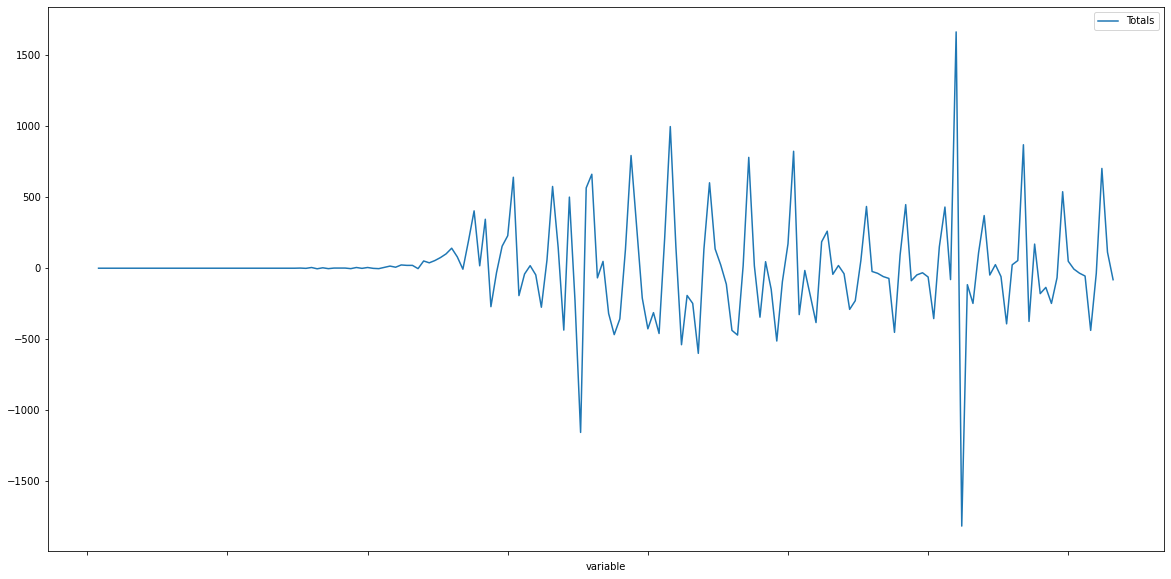

In [229]:
# dickey_fuller_test(death_total_diff2.values)
death_total_diff2.plot(figsize=(20,10))

<p> The twice diffenced data almost looks stationary, hoawever, variance might be not be </p>

In [240]:
dickey_fuller_test(three_times_dif[3:])

Test statistic = -2.897
P-value = 0.346
Critical values :
	1%: -4.442311322809018 - The data is not stationary with 99% confidence
	5%: -3.868445623247818 - The data is not stationary with 95% confidence
	10%: -3.5755117595275863 - The data is not stationary with 90% confidence


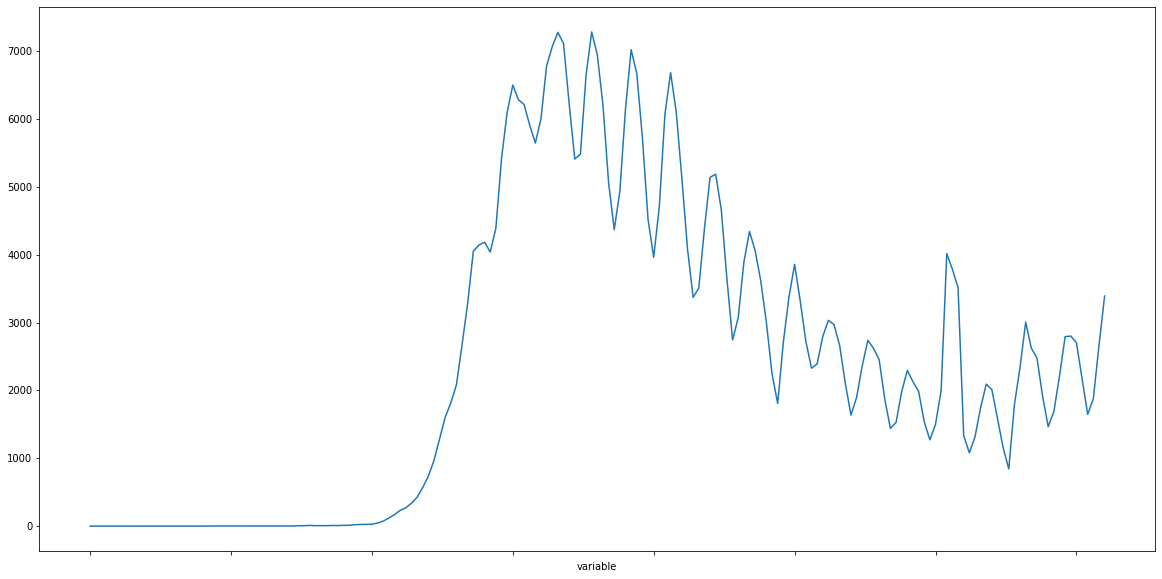

In [243]:
three_times_dif[3:].plot(figsize=(20,10))

### Modeling

<p> Modeling death totals. Our metric will be RMSE. Root Mean Squared Error will tell use the diffence between the actual number of cases and the predicted number of cases. </p>

In [172]:
test_dates = '2020-07-09'
training_dates_start = '2020-03-10'
training_dates_end = '2020-07-08'

testing_set_values = dt_diff3[test_dates:]
testing_set = dt_diff3[test_dates:].drop('Totals',axis=1)
training_set = dt_diff3[training_dates_start:training_dates_end]

In [249]:
dickey_fuller_test(training_set)

Test statistic = -9.094
P-value = 0.000
Critical values :
	1%: -4.477689308235012 - The data is  stationary with 99% confidence
	5%: -3.886199351653608 - The data is  stationary with 95% confidence
	10%: -3.5864021947601583 - The data is  stationary with 90% confidence


## ARMA - Models

In [211]:
### Baseline Model

run_arma(death_data['Totals'], 1,0)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Totals   No. Observations:                  184
Model:                     ARMA(1, 0)   Log Likelihood               -1553.707
Method:                       css-mle   S.D. of innovations           1099.140
Date:                Wed, 29 Jul 2020   AIC                           3113.414
Time:                        23:46:53   BIC                           3123.059
Sample:                    01-22-2020   HQIC                          3117.323
                         - 07-23-2020                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         5.665e+04   7.65e+04      0.741      0.459   -9.33e+04    2.07e+05
ar.L1.Totals     0.9999      0.000   6050.602      0.000       1.000       1.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

In [250]:
run_arma(training_set,1,0)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Totals   No. Observations:                  121
Model:                     ARMA(1, 0)   Log Likelihood                -928.017
Method:                       css-mle   S.D. of innovations            517.825
Date:                Thu, 30 Jul 2020   AIC                           1862.035
Time:                        09:49:38   BIC                           1870.422
Sample:                    03-10-2020   HQIC                          1865.441
                         - 07-08-2020                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1518     32.294      0.005      0.996     -63.144      63.447
ar.L1.Totals    -0.4616      0.082     -5.636      0.000      -0.622      -0.301
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.1663           +0.0000j            2.1663            0.5000
-----------------------------------------------------------------------------
"""

In [271]:
mod_arma = ARMA(training_set, order=(1,0))
res_arma = mod_arma.fit()
pred_deaths = res_arma.predict()
np.sqrt(metrics.mean_squared_error(training_set, pred_deaths))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


517.8248082571719

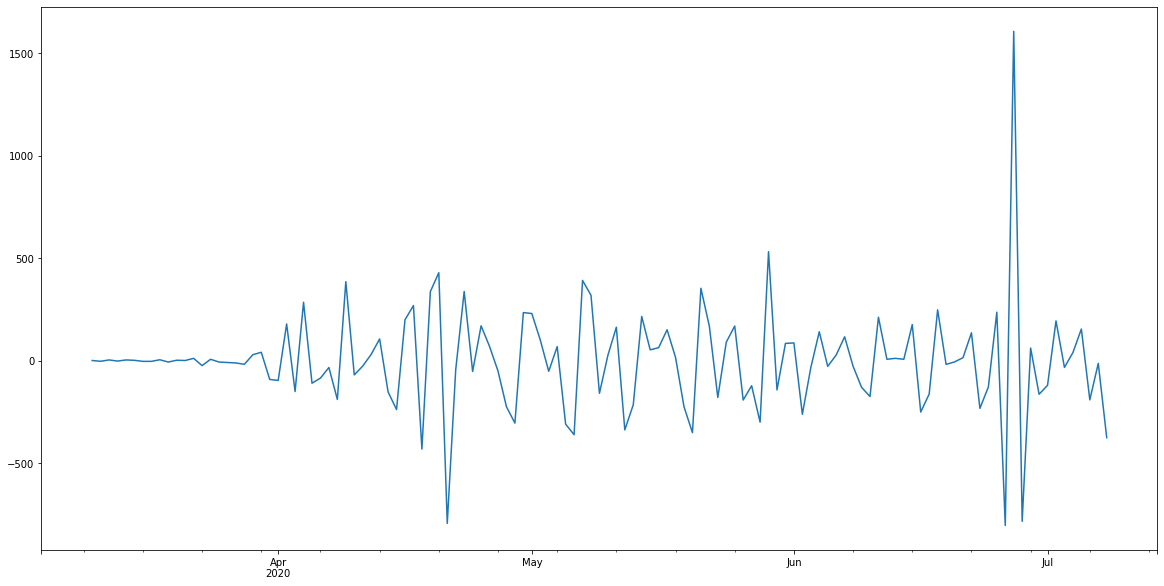

In [272]:
pred_deaths.plot(figsize=(20,10))

In [267]:
mod_arma = ARMA(testing_set_values, order=(1,0))
res_arma = mod_arma.fit()
pred_deaths = res_arma.predict()
np.sqrt(metrics.mean_squared_error(testing_set_values, pred_deaths))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


380.76285560393376

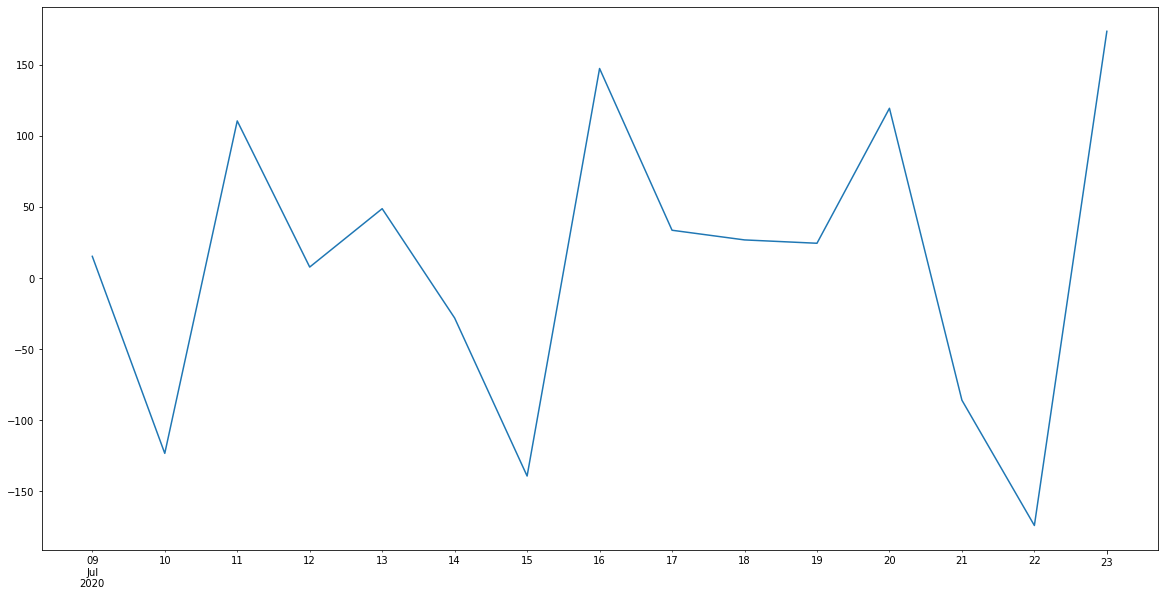

In [269]:
pred_deaths.plot(figsize=(20,10))

<p> Based on the test above, the testing set has a lower RMSE than the training, indicating that the model isn't overfitting to the data.</p>

## SARIMAX - Death

In [317]:
def sarimax_model(dataframe, p,d,q):
    ans = {}
    test_dates = '2020-07-09'
    training_dates_start = '2020-03-10'
    training_dates_end = '2020-07-08'

    testing_set_values = dataframe[test_dates:]
    testing_set = dataframe[test_dates:]
    training_set = dataframe[training_dates_start:training_dates_end]

    
    mod = sm.tsa.statespace.SARIMAX(training_set, trend='ctt', order=(int(p),int(d),int(q)))
    res = mod.fit()
    preds = res.predict()
    ans['Training_Results'] = res.summary()
    ans['Training_RMSE'] = np.sqrt(metrics.mean_squared_error(training_set,preds))
    ans['Training_Predictions'] = preds
    
    test_mod = sm.tsa.statespace.SARIMAX(testing_set_values, trend='ctt', order=(int(p),int(d),int(q)))
    test_res = test_mod.fit()
    test_preds = test_res.predict()
    ans['Testing_Results'] = test_res.summary()
    ans['Testing_RMSE'] = np.sqrt(metrics.mean_squared_error(testing_set_values,test_preds))
    ans['Testing_Predictions'] = test_preds
                
    return ans
    

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


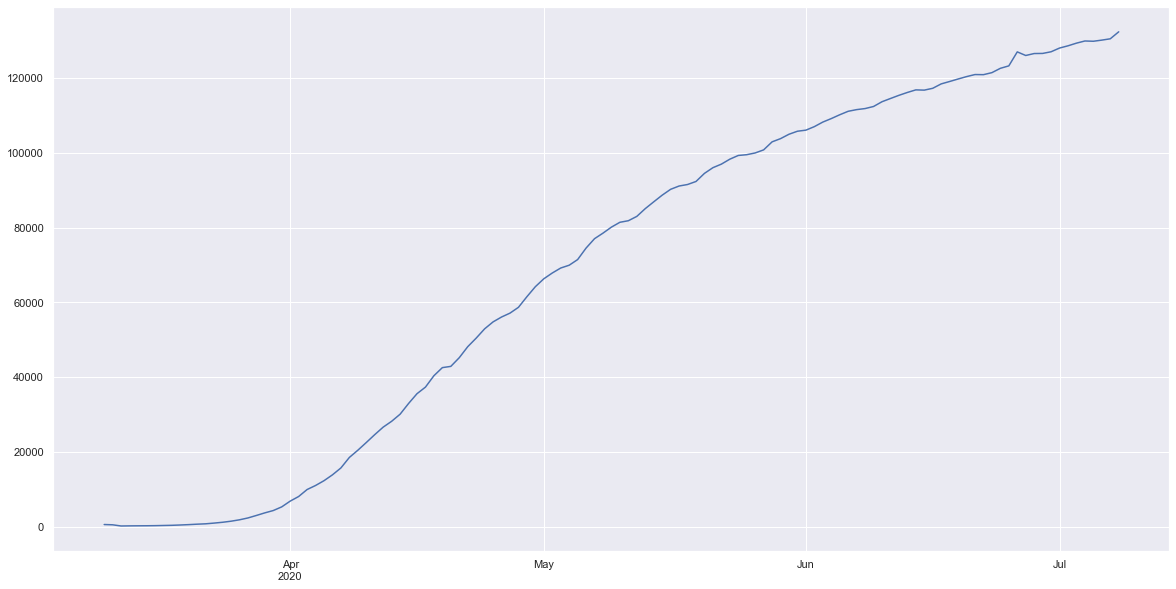

In [318]:
first_model_sarimax = sarimax_model(death_data['Totals'],1,1,1)
first_model_sarimax['Training_Predictions'].plot(figsize=(20,10))

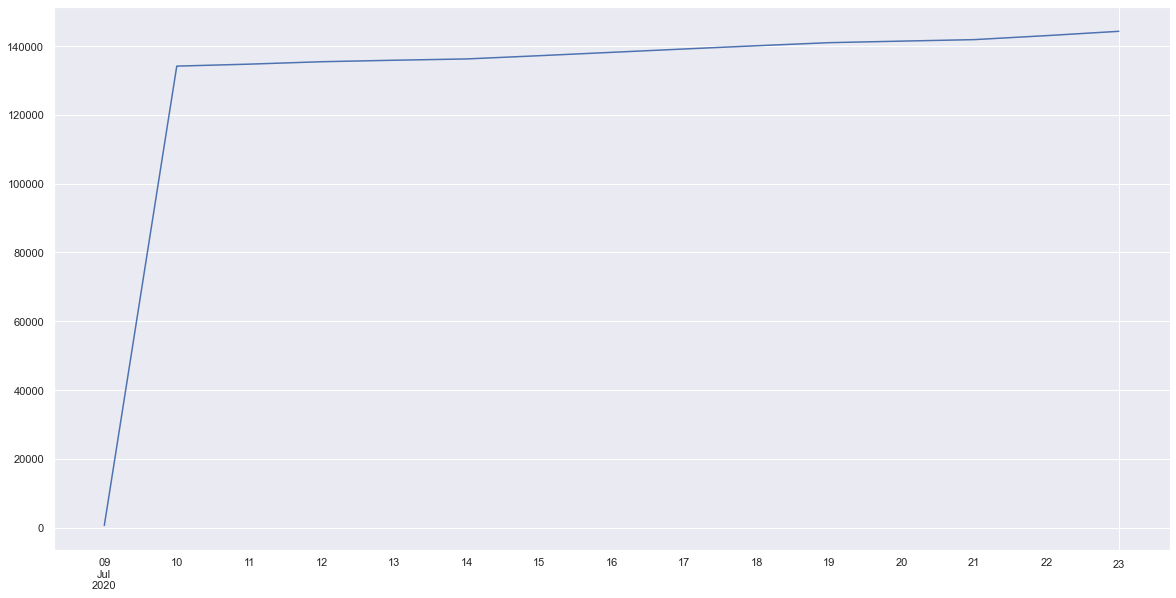

In [319]:
first_model_sarimax['Testing_Predictions'].plot(figsize=(20,10))

In [320]:
### Modeling with Differenced Data
death_data_twice_diff = differencing(death_data,2)
twice_diff_sarimax = sarimax_model(death_data_twice_diff, 1,2,1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.

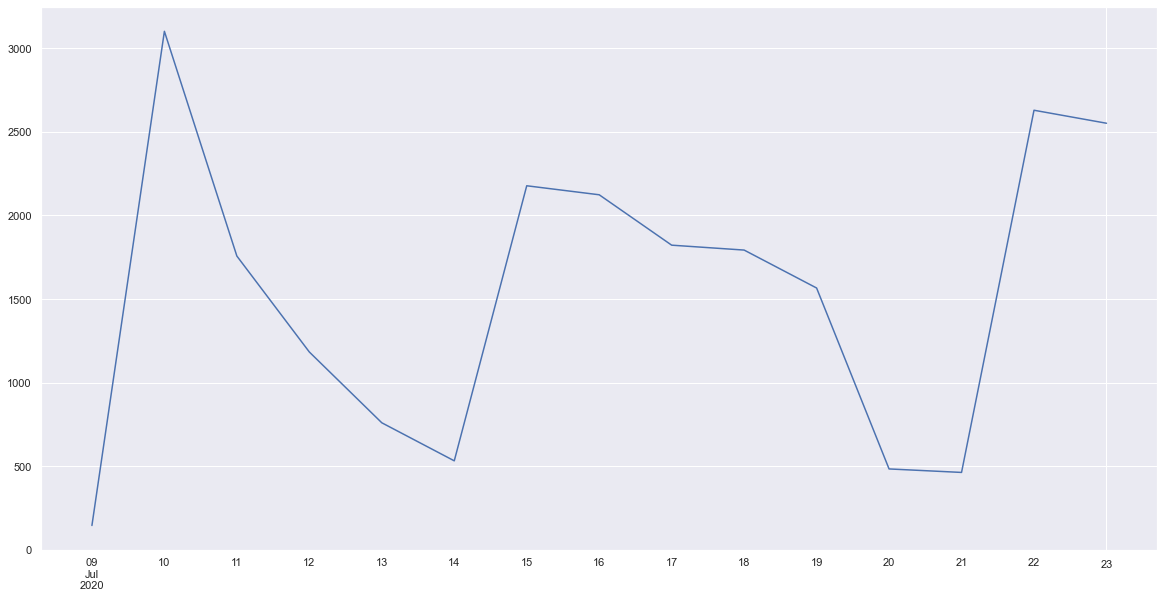

In [321]:
twice_diff_sarimax['Testing_Predictions'].plot()

In [322]:
print(twice_diff_sarimax['Training_RMSE'])
print(twice_diff_sarimax['Testing_RMSE'])

520.4070830584468
663.231638199682


<p> Based on the higher Testing RMSE, we can see that the model maybe overfitting to the data. </p>

In [325]:
three_times_diff = differencing(death_data,3)
three_times_sarimax = sarimax_model(three_times_diff,1,3,1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


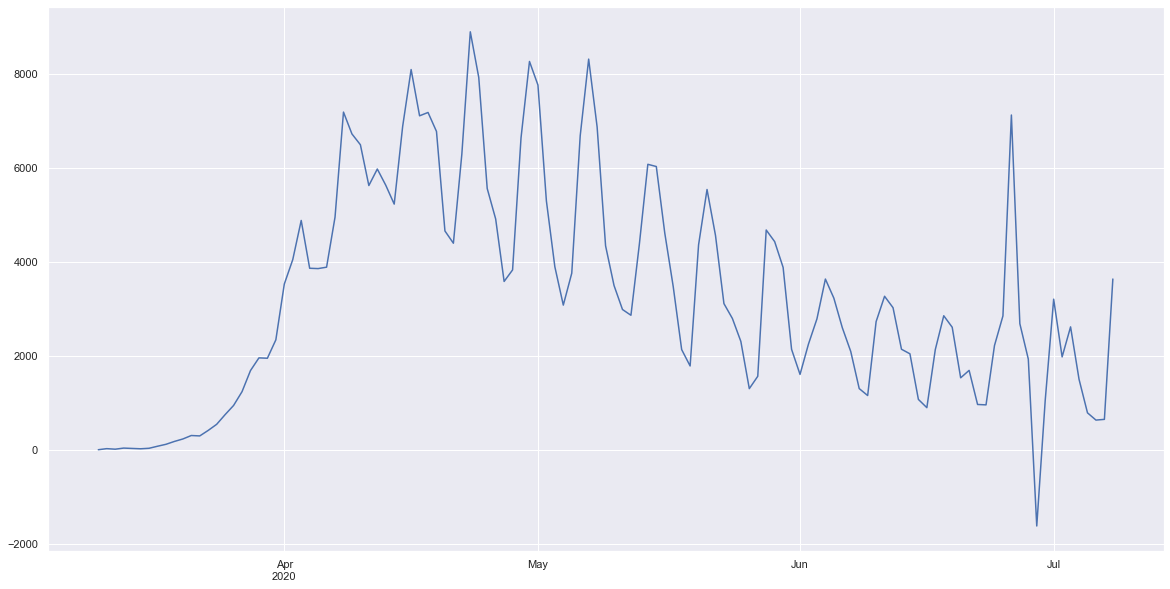

In [326]:
three_times_sarimax['Training_Predictions'].plot(figsize=(20,10))

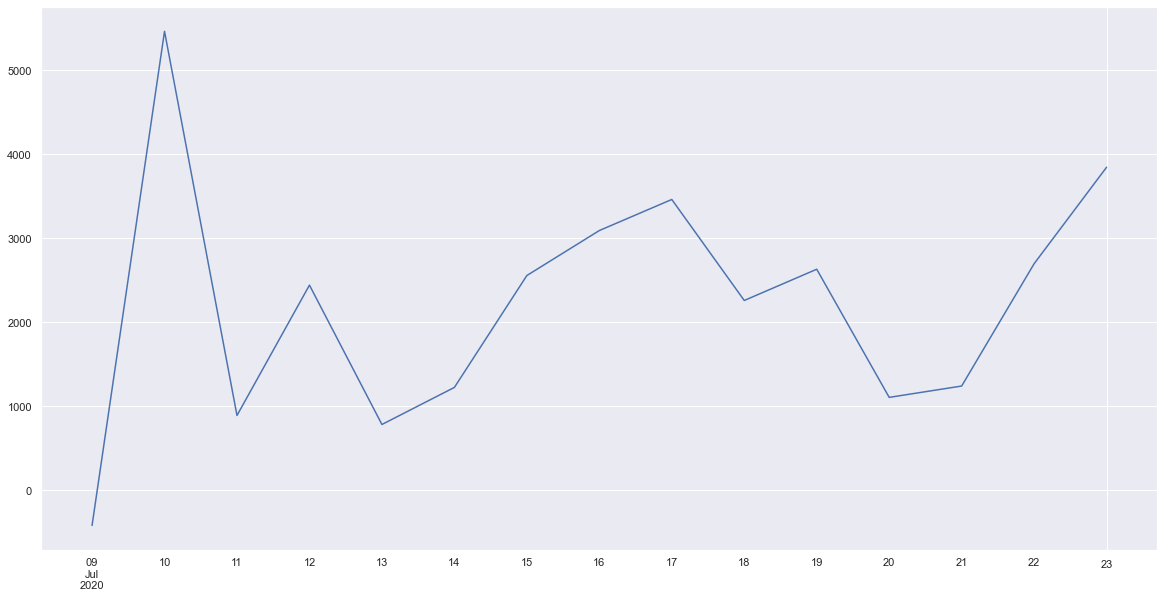

In [327]:
three_times_sarimax['Testing_Predictions'].plot(figsize=(20,10))

In [328]:
print(three_times_sarimax['Training_RMSE'])
print(three_times_sarimax['Testing_RMSE'])

726.4868777772701
1296.4847367704288


<p>This model overfits to the training data</p>